In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from pathlib import Path
import seaborn as sns

# Get the base directory = parent of the current notebook
BASE_DIR = Path.cwd().parent   

# Now build data path
data_path = BASE_DIR / "1. data" / "processed"


# 1. Read CSV
df = pd.read_csv(data_path / "Combined_IT_Data_Final.csv")
df = df.rename(columns={"or": "op_rev"})

# 3. Create Scenarios by applying simple filters
df = df[df["net_worth"] > 0]  
df = df[df["persistent_loss"] == 0]  
df = df[df["op_rev"].between(1, 20000)]                       
df = df[df["pli"].between(-1, 50)]
#df = df[df["export_income_pct"] >= 75]        
df = df[df["emp_cost_pct"] >= 25]             
df = df[df["service_income_pct"] >= 75]  


df.shape


(3992, 15)

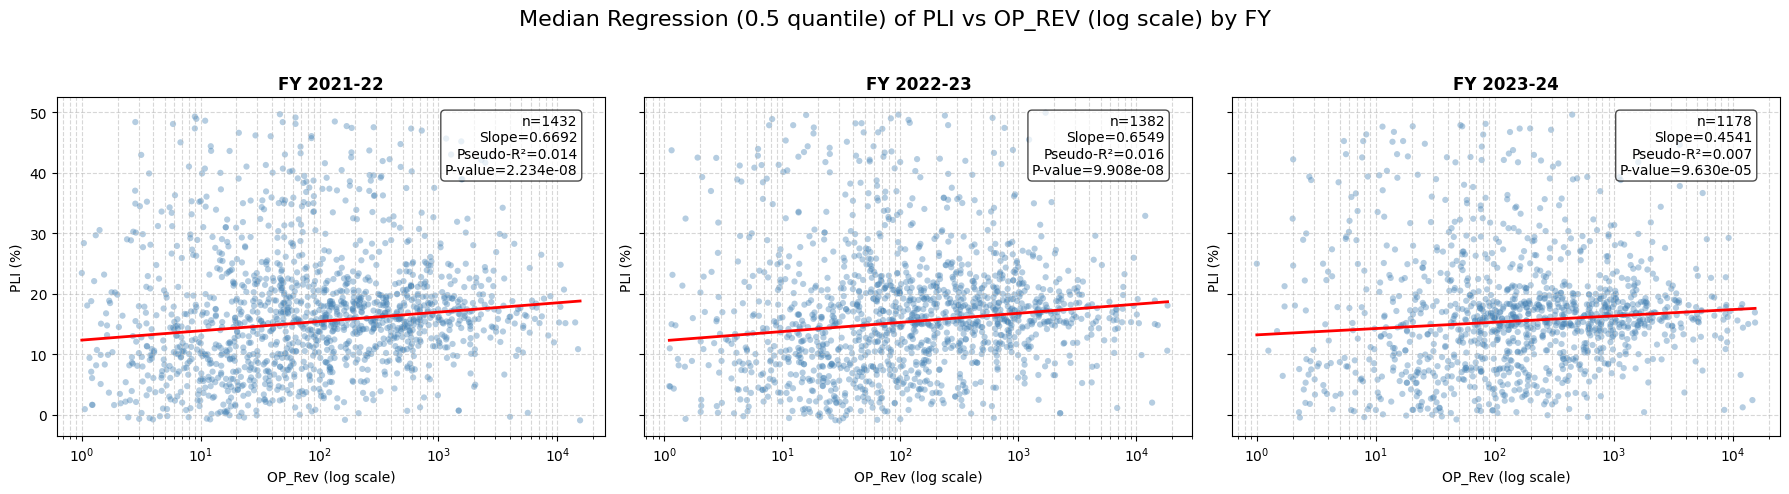

,FY,n_obs,Slope,Pseudo_R²,P-value
0,2021-22,1432,0.669236,0.013672,2.233525e-08
1,2022-23,1382,0.654932,0.015542,9.908176e-08
2,2023-24,1178,0.454091,0.006945,9.630485e-05


In [5]:
# FY-wise median regression with stats annotations (regressing on log(op_rev), plotting on log scale)
fy_list = sorted(df['fy'].unique())  # sorted FYs
fig, axes = plt.subplots(1, len(fy_list), figsize=(6*len(fy_list),5), sharey=True)

# Store results
results_list = []

for i, fy in enumerate(fy_list):
    ax = axes[i] if len(fy_list) > 1 else axes
    temp_df = df[df['fy']==fy][['op_rev','pli']].dropna().copy()
    
    # Add log(op_rev)
    temp_df["log_op_rev"] = np.log(temp_df["op_rev"])
    
    # Scatter plot (original op_rev on x-axis, log scale)
    ax.scatter(temp_df['op_rev'], temp_df['pli'], 
               alpha=0.4, color='steelblue', edgecolor='none', s=20)  # smaller & lighter
    
    # Median regression
    model = smf.quantreg('pli ~ log_op_rev', temp_df)
    res = model.fit(q=0.5)
    
    # Regression line (map back from log scale to original x)
    x_log = np.linspace(temp_df["log_op_rev"].min(), temp_df["log_op_rev"].max(), 200)
    x_orig = np.exp(x_log)
    y = res.params["Intercept"] + res.params["log_op_rev"] * x_log
    ax.plot(x_orig, y, color='red', lw=2)
    
    # Extract statistics
    n_obs = temp_df.shape[0]
    slope = res.params['log_op_rev']
    pval = res.pvalues['log_op_rev']
    pseudo_r2 = res.prsquared

    # Save for table
    results_list.append({
        "FY": fy,
        "n_obs": n_obs,
        "Slope": slope,
        "Pseudo_R²": pseudo_r2,
        "P-value": pval
    })
    
    # Annotate stats inside plot
    ax.text(0.95, 0.95,
            f"n={n_obs}\nSlope={slope:.4f}\nPseudo-R²={pseudo_r2:.3f}\nP-value={pval:.3e}",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    
    ax.set_title(f"FY {fy}", fontsize=12, fontweight="bold")
    ax.set_xscale("log")  # log scale on original axis
    ax.set_xlabel("OP_Rev (log scale)")
    ax.set_ylabel("PLI (%)")
    ax.grid(True, which="both", ls="--", alpha=0.5)

plt.suptitle("Median Regression (0.5 quantile) of PLI vs OP_REV (log scale) by FY", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

# Display table
import IPython.display as display
display.display(results_df)


In [7]:
# Standard OP_REV values for prediction
standard_or = [1, 100, 300, 500, 1000, 1500, 2000, 3000, 5000, 10000, 20000]

# Prepare list to store predictions
pred_list = []

fy_list = sorted(df['fy'].unique())

for fy in fy_list:
    temp_df = df[df['fy']==fy][['op_rev','pli']].dropna().copy()
    temp_df["log_op_rev"] = np.log(temp_df["op_rev"])
    
    # Fit median regression
    model = smf.quantreg('pli ~ log_op_rev', temp_df)
    res = model.fit(q=0.5)
    
    # Predict median PLI for standard OP_REV values (using log)
    for or_val in standard_or:
        log_val = np.log(or_val)
        pred_pli = res.params['Intercept'] + res.params['log_op_rev'] * log_val
        pred_list.append({
            'FY': fy,
            'OP_REV': or_val,
            'Predicted_PLI': round(pred_pli, 2)
        })

# Convert to DataFrame
pred_df = pd.DataFrame(pred_list)

# Pivot table: OP_REV as rows, FYs as columns
prediction_table = pred_df.pivot(index='OP_REV', columns='FY', values='Predicted_PLI')

# Add a column for average of all FYs
prediction_table['Average'] = prediction_table.mean(axis=1).round(2)

# Display table
prediction_table


FY,2021-22,2022-23,2023-24,Average
OP_REV,,,,
1,12.37,12.28,13.23,12.63
100,15.45,15.29,15.33,15.36
300,16.18,16.01,15.83,16.01
500,16.53,16.35,16.06,16.31
1000,16.99,16.80,16.37,16.72
1500,17.26,17.07,16.56,16.96
2000,17.45,17.25,16.69,17.13
3000,17.73,17.52,16.87,17.37
5000,18.07,17.85,17.10,17.67


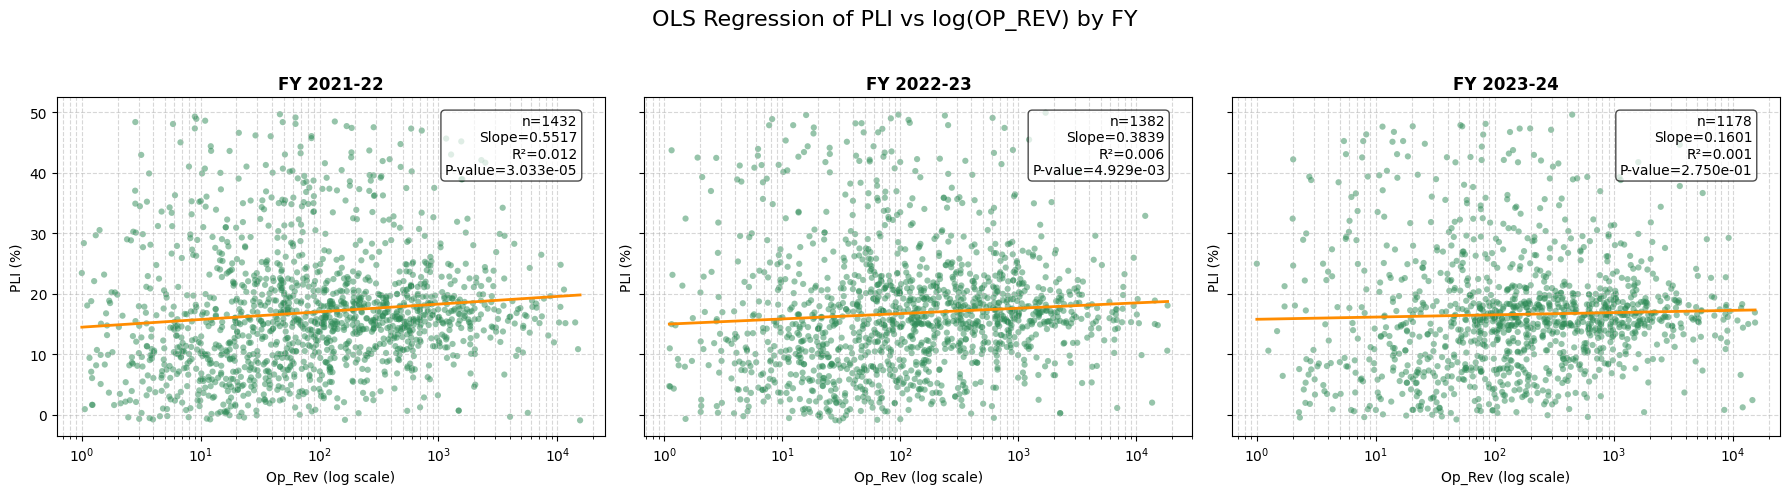

,FY,n_obs,Slope,R²,P-value
0,2021-22,1432,0.551689,0.012096,0.000030
1,2022-23,1382,0.383916,0.005714,0.004929
2,2023-24,1178,0.160128,0.001013,0.274999


In [15]:
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

# FY-wise OLS regression with stats annotations (log(op_rev))
fy_list = sorted(df['fy'].unique())  # sorted FYs
fig, axes = plt.subplots(1, len(fy_list), figsize=(6*len(fy_list),5), sharey=True)


# Store results
results_list = []

for i, fy in enumerate(fy_list):
    ax = axes[i] if len(fy_list) > 1 else axes
    temp_df = df[df['fy']==fy][['op_rev','pli']].dropna().copy()
    
    # Add log(op_rev)
    temp_df["log_op_rev"] = np.log(temp_df["op_rev"])
    
    # Scatter plot (original op_rev on log scale)
    ax.scatter(temp_df['op_rev'], temp_df['pli'], 
               alpha=0.5, color='seagreen', edgecolor='none', s=20)
    
    # OLS regression
    model = smf.ols('pli ~ log_op_rev', temp_df)
    res = model.fit()
    
    # Regression line (map back from log scale to original op_rev)
    x_log = np.linspace(temp_df["log_op_rev"].min(), temp_df["log_op_rev"].max(), 200)
    x_orig = np.exp(x_log)
    y = res.params["Intercept"] + res.params["log_op_rev"] * x_log
    ax.plot(x_orig, y, color='darkorange', lw=2)
    
    # Extract statistics
    n_obs = temp_df.shape[0]
    slope = res.params['log_op_rev']
    pval = res.pvalues['log_op_rev']
    r2 = res.rsquared

    # Save for table
    results_list.append({
        "FY": fy,
        "n_obs": n_obs,
        "Slope": slope,
        "R²": r2,
        "P-value": pval
    })

    
    
    # Annotate stats inside plot
    ax.text(0.95, 0.95,
            f"n={n_obs}\nSlope={slope:.4f}\nR²={r2:.3f}\nP-value={pval:.3e}",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    
    ax.set_title(f"FY {fy}", fontsize=12, fontweight="bold")
    ax.set_xscale("log")
    ax.set_xlabel("Op_Rev (log scale)")
    ax.set_ylabel("PLI (%)")
    ax.grid(True, which="both", ls="--", alpha=0.5)

plt.suptitle("OLS Regression of PLI vs log(OP_REV) by FY", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

# Display table
import IPython.display as display
display.display(results_df)

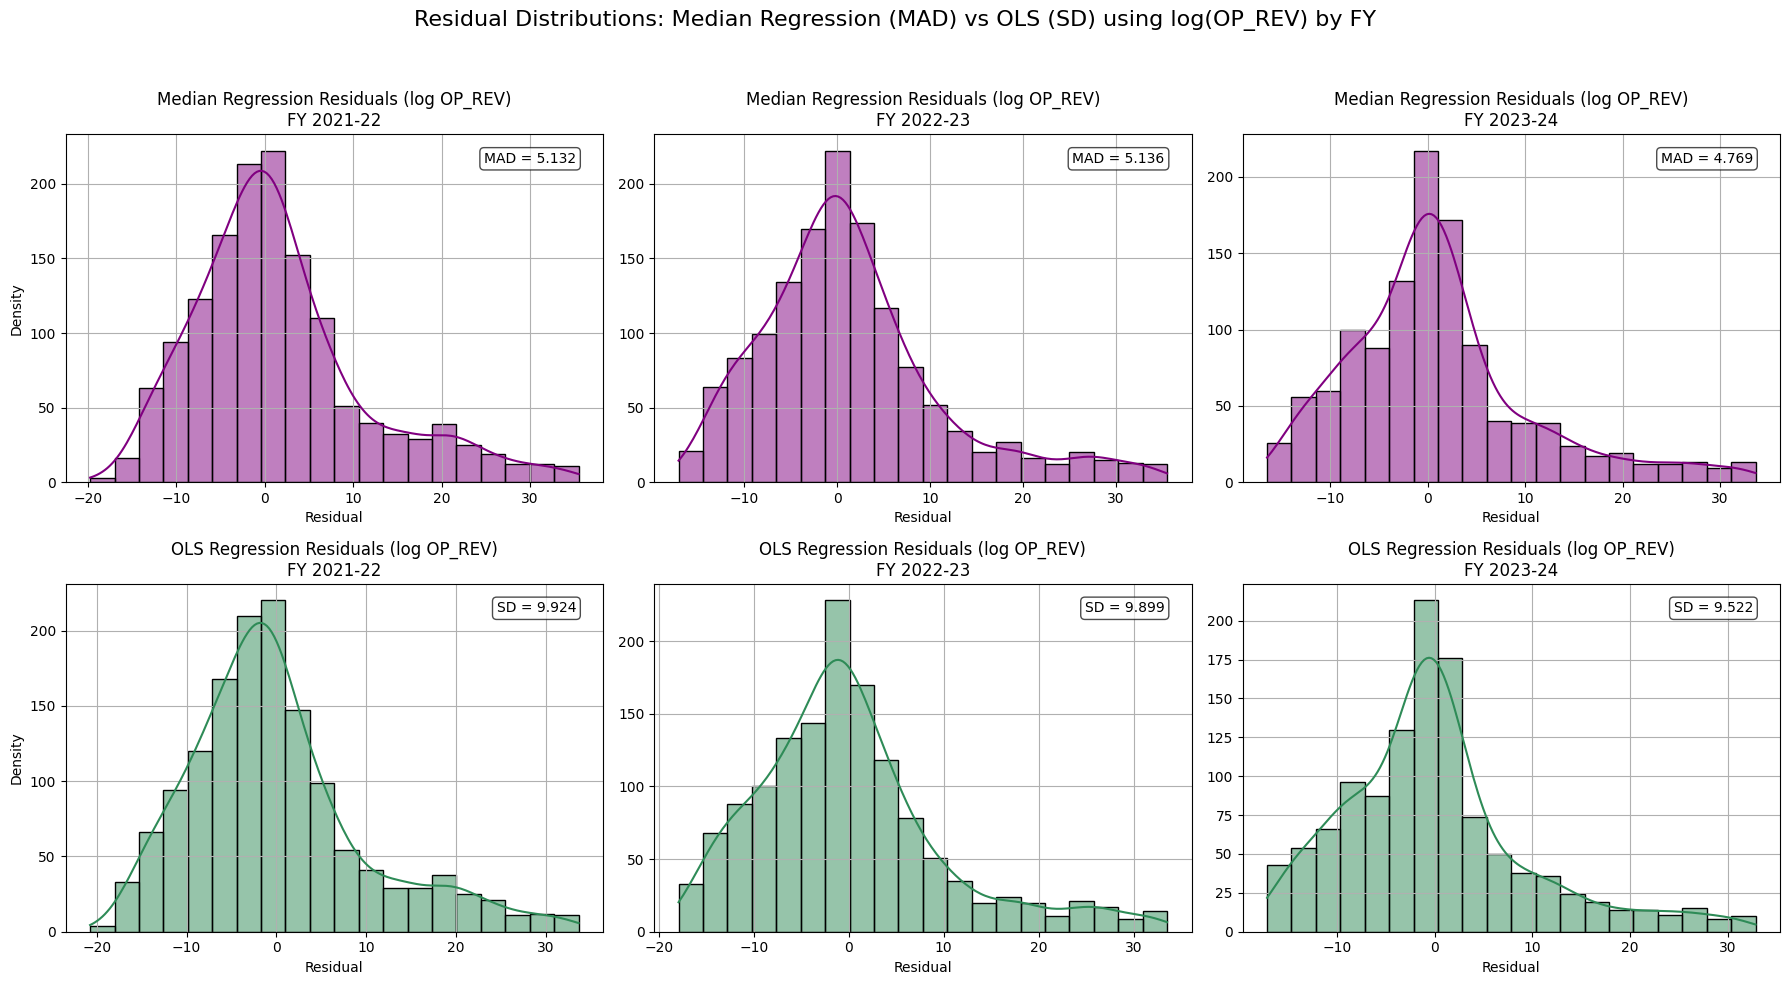

,FY,MAD (Median Regression),SD (OLS Regression),n_obs
0,2021-22,5.132410,9.924304,1432
1,2022-23,5.135860,9.898594,1382
2,2023-24,4.768779,9.522348,1178


In [19]:
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

fy_list = sorted(df['fy'].unique())
fig, axes = plt.subplots(2, len(fy_list), figsize=(6*len(fy_list),10), sharey=False)

# Store results
results_list = []


for i, fy in enumerate(fy_list):
    # Subset
    temp_df = df[df['fy'] == fy][['op_rev','pli']].dropna().copy()
    temp_df["log_op_rev"] = np.log(temp_df["op_rev"])
    
    # ---------- Median Regression (log(op_rev)) ----------
    ax = axes[0, i] if len(fy_list) > 1 else axes[0]
    model_q = smf.quantreg('pli ~ log_op_rev', temp_df)
    res_q = model_q.fit(q=0.5)
    
    temp_df['residual_q'] = temp_df['pli'] - (res_q.params['Intercept'] + res_q.params['log_op_rev'] * temp_df['log_op_rev'])
    sns.histplot(temp_df['residual_q'], kde=True, ax=ax, color='purple', bins=20)
    
    mad = np.median(np.abs(temp_df['residual_q']))
    ax.text(0.95, 0.95, f"MAD = {mad:.3f}", transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    
    ax.set_title(f"Median Regression Residuals (log OP_REV)\nFY {fy}")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Density" if i==0 else "")
    ax.grid(True)
    
    # ---------- OLS Regression (log(op_rev)) ----------
    ax = axes[1, i] if len(fy_list) > 1 else axes[1]
    model_ols = smf.ols('pli ~ log_op_rev', temp_df)
    res_ols = model_ols.fit()
    
    temp_df['residual_ols'] = res_ols.resid
    sns.histplot(temp_df['residual_ols'], kde=True, ax=ax, color='seagreen', bins=20)
    
    sd_resid = temp_df['residual_ols'].std()
    ax.text(0.95, 0.95, f"SD = {sd_resid:.3f}", transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    
    ax.set_title(f"OLS Regression Residuals (log OP_REV)\nFY {fy}")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Density" if i==0 else "")
    ax.grid(True)

    # Save results for table
    results_list.append({
        "FY": fy,
        "MAD (Median Regression)": mad,
        "SD (OLS Regression)": sd_resid,
        "n_obs": temp_df.shape[0]
    })

plt.suptitle("Residual Distributions: Median Regression (MAD) vs OLS (SD) using log(OP_REV) by FY", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])


plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

# Display results as text table
import IPython.display as display
display.display(results_df)
